In [ ]:
# Let's start with PyTorch!
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
"""
Warum der Exkurs über Klassen in Lektion 9?
In PyTorch ist es Konvention Models als Klasse zu definieren, die von der PyTorch-Klasse 'nn.Module' erben.
Die Layers eines Models werden durch den Konstruktor im Objekt gespeichert und dann eine Methode
'forward()' definiert, die die Layers über einem Input sequentiell ausführt.
Definieren wir also eine Encoder-Klasse, die 3 Convolutional Layers mit Strides und ein FC-Layer beinhaltet.

Beachte: die Dimensionen in PyTorch folgen einer anderen Konvention als in Tensorflow.
In Tensorflow : (batch_dimension, Höhe, Breite, Features)
In PyTorch    : (batch_dimension, Features, Höhe, Breite)
"""

class Encoder_Model(nn.Module):
    # ------------------------------------------------- #
    # Konstruktor
    def __init__(self):
        super().__init__()
        # Conv (1, 28, 28) -> (16, 14, 14)
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=16, 
            kernel_size=3, 
            stride=2,
            padding=(1,1))

        # Conv (16, 14, 14) -> (32, 7, 7)
        self.conv2 = nn.Conv2d(
            in_channels=16, 
            out_channels=32, 
            kernel_size=3, 
            stride=2,
            padding=(1,1))

        # Conv (32, 7, 7) -> (64, 4, 4)
        self.conv3 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=3, 
            stride=2,
            padding=(1,1))

        # FC Layer (576,) -> (9,)
        self.fc_mean = nn.Linear(
            in_features=4*4*64,
            out_features=9)

        # FC Layer (576,) -> (9,)
        self.fc_logvar = nn.Linear(
            in_features=4*4*64,
            out_features=9)

    # ------------------------------------------------- #
    # forward-Methode
    def forward(self, image_input):
        # Conv 1 mit Relu
        x = self.conv1(image_input)
        x = torch.relu(x)
        # Conv 2 mit Relu
        x = self.conv2(x)
        x = torch.relu(x)
        # Conv 3 mit Relu
        x = self.conv3(x)
        x = torch.relu(x)
        # Flattening der Featuremap, dann Fully-Connected
        x = torch.flatten(x, start_dim=1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

In [ ]:
# Model definieren
Encoder = Encoder_Model()

In [ ]:
# Kurzer Test, ob alles wie gewünscht funktioniert. 
x = torch.randn(1, 1, 28, 28)
z = Encoder.forward(x)
print(z.shape)

# Seems good!

torch.Size([1, 9])


In [ ]:
"""
Bauen wir nun den Decoder als symmetrisches Gegenstück zum Encoder.
Wir haben zum Upsamplen zwei Möglichkeiten: UpSampling (Gegenstück zum Pooling) oder sog. Transposed Convolutions/Deconvolutions
(Gegenstück zur Strided Convolution). In diesem Notebook wählen wir letztere.
Dadurch, dass 28 (die Seitenlänge von MNIST) keine Potenz von 2 ist, ist es mit dem padding und den Kernelgrößen ein gewisses Gepfusche.
Allerdings gibt es im Grunde keine zwingenden Argumente dafür, dass ein Model, welches mit etwas 'unregelmäßigen' Parametern gebaut wird,
schlechter performen sollte als ein Model, dessen Seitenlängen in den Layern bspw. immer Vielfache von 2 sind.
Das ist letzten Endes eine ästhetische Entscheidung zugunsten von Klarheit und Übersicht und ist nicht primär durch Performance motiviert.
"""
class Decoder_Model(nn.Module):
    # ------------------------------------------------- #
    # Konstruktor
    def __init__(self):
        super().__init__()
        # FC Layer
        self.fc = nn.Linear(
            in_features=9,
            out_features=4*4*64)
        
        # Conv2Dtrans1
        self.convtrans1 = nn.ConvTranspose2d(
            in_channels=64, 
            out_channels=32, 
            kernel_size=3,
            stride=2,
            padding=(1,1))

        # Conv2Dtrans2
        self.convtrans2 = nn.ConvTranspose2d(
            in_channels=32, 
            out_channels=16, 
            kernel_size=3,
            stride=2,
            padding=(1,1))

        # Conv2Dtrans3
        self.convtrans3 = nn.ConvTranspose2d(
            in_channels=16, 
            out_channels=1, 
            kernel_size=4,
            stride=2,
            padding=(0,0))

    # ------------------------------------------------- #
    # forward-Methode
    def forward(self, latent_code_input):
        # FC, anschließend reshapen wir den Vektor zu einer Matrix (64, 4, 4)
        x = self.fc(latent_code_input)
        x = torch.relu(x)
        x = torch.reshape(x, (x.shape[0], 64, 4, 4))
        # Deconvolution 1
        x = self.convtrans1(x)
        x = torch.relu(x)
        # Deconvolution 2
        x = self.convtrans2(x)
        x = torch.relu(x)
        # Deconvolution 3
        x = self.convtrans3(x)
        return x

In [ ]:
# Model definieren
Decoder = Decoder_Model()

In [ ]:
x = torch.randn(1, 9)
z = Decoder.forward(x)
print(z.shape)

# Gut, die Models stehen.

torch.Size([1, 1, 28, 28])


In [ ]:
# Schnappen wir uns unsere GPU bzw. CPU wenn keine GPU vorhanden ist.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Nun kopieren wir unsere Models auf das device mit der Methode .to
Encoder = Encoder.to(device)
Decoder = Decoder.to(device)

# Den Optimizern in PyTorch übergeben wir die Methode 'parameters' des zu optimierenden Models und die learning rate.
opt_encoder = torch.optim.Adam(Encoder.parameters(), lr=1e-3)
opt_decoder = torch.optim.Adam(Decoder.parameters(), lr=1e-3)

'''
Loss-Functions in PyTorch funktionieren wie in Tensorflow. Wir brauchen eine Funktion mit zwei Argumenten (pred, label),
die den entsprechenden Fehler errechnet und zurückgibt. Wir wählen für den Autoencoder den 'Mean Squared Error', mit dem wir auch
unsere allerersten NNs optimiert haben. Hier bedeutet das, dass für jede Pixelposition der quadrierte Unterschied zwischen dem jeweiligen
Pixel im Originalbild/Label und der Rekonstruktion durch das Model berechnet wird. Wir erhalten also 28x28 Skalare. Aus diesen wird dann der
'mean'/Durchschnitt berechnet, um einen einzigen Skalar zu produzieren.
'''
def mse_loss(pred, label):
    loss = torch.mean((pred - label)**2)
    return loss

In [ ]:
'''
Laden wir nun MNIST. Die Methode torchvision.datasets.MNIST() gibt uns ein Torch-Dataset-Objekt, welches iterierbar ist und Pillow-Images beinhaltet.
(Pillow ist eine Bildlibrary mit eigener Datenstruktur. Analog für Numpy wäre ein Numpy-Array). Wir müssten die Images selbst zu Pytorch-Tensoren konvertieren,
doch glücklicherweise gibt es in PyTorch sog. 'transforms', die an die obige Methode übergeben werden können und die Konvertierung für uns automatisieren. 
'''
import torchvision

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", transform=transform, train=True, download=True)

'''
Das DataLoader-Objekt in PyTorch ist quasi analog zum Tensorflow-Dataset. Mit num_workers können wir die Anzahl der CPU-Kerne einstellen, die Daten
abgreifen und an unser Device weiterleiten.
'''

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def sample_z(z_mean, z_log_var):
    noise = torch.randn_like(z_mean, device=z_mean.device)
    scale = torch.exp(0.5 * z_log_var)
    z = z_mean + scale * noise
    kl_loss = torch.mean(-0.5 * (1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var)))
    return z, kl_loss

In [ ]:
'''
Trainingsloop
'''
from tqdm import tqdm

def train(n_epochs):
    for epoch in range(n_epochs):
        rec_loss_epoch = 0
        kl_loss_epoch = 0
        pbar = tqdm(train_loader)
        for batch_images, _ in pbar:
            # Batch auf das device laden
            batch_images = batch_images.to(device)
            # Gradienten resetten.
            opt_encoder.zero_grad()
            opt_decoder.zero_grad()
            # encodieren
            batch_means, batch_logvars = Encoder(batch_images)
            batch_latent_codes, kl_loss = sample_z(batch_means, batch_logvars)
            # decodieren
            batch_reconstructions = Decoder(batch_latent_codes)
            # loss berechnen
            rec_loss = mse_loss(batch_reconstructions, batch_images)
            total_loss = rec_loss + kl_loss * 0.01
            # Gradienten berechnen
            total_loss.backward()
            # Gewichte anhand der Gradienten updaten
            opt_encoder.step()
            opt_decoder.step()
            # Loss zum gesamten Loss der Epoche hinzufügen
            rec_loss_epoch += rec_loss.item()
            kl_loss_epoch += kl_loss.item()
        
        # Durchschnittlichen Loss der Epoche berechnen
        rec_loss_epoch = rec_loss_epoch / len(train_loader)
        kl_loss_epoch = kl_loss_epoch / len(train_loader)
        
        # Loss der Epochen anzeigen
        print(epoch + 1, n_epochs, rec_loss_epoch, kl_loss_epoch)

train(n_epochs=20)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 469/469 [00:36<00:00, 12.76it/s]


1 20 0.040722532610871644 0.8219094376361251


100%|██████████| 469/469 [00:36<00:00, 12.98it/s]


2 20 0.028212756534089157 1.1646651121090725


100%|██████████| 469/469 [00:34<00:00, 13.56it/s]


3 20 0.026146361695677994 1.2166021515819818


100%|██████████| 469/469 [00:34<00:00, 13.64it/s]


4 20 0.025085621277120575 1.23898361461249


  6%|▌         | 27/469 [00:02<00:38, 11.50it/s]


KeyboardInterrupt: ignored

In [ ]:
"""
Def Loss scheint nicht weiter zu sinken, d.h. unser NN ist bereits am Limit. Visualisieren wir einmal die Rekonstruktions-Fähigkeit des Models.
"""
def plot_results(imgs):
    plt.figure(figsize=(10, 10))
    # MNIST hat die Norm [0, 1], daher müssen wir mit 255 multiplizieren, um auf uint8 zu konvertieren
    imgs = [np.uint8(np.clip(img*255, 0, 255)) for img in imgs]
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.axis("off")

test_examples = []
for i in range(9):
    x = torch.unsqueeze(train_dataset[i][0], 0)
    test_examples.append(x)
test_examples = torch.concat(test_examples)

test_reconstructions = Decoder(Encoder(test_examples))
# Original und Rekonstruktion entlang der Breite konkatenieren
im_vergleich = [np.concatenate((x.cpu().detach().numpy(), y.cpu().detach().numpy()), axis=2) for x, y in zip(test_examples, test_reconstructions)]
im_vergleich = [np.transpose(x, (1,2,0)) for x in im_vergleich]

In [ ]:
a = torch.randn((1,9)).to(device)
b = torch.randn((1,9)).to(device)

zs = []
ws = np.linspace(0,1,9)
for w in ws:
  print(w, (1-w))
  z = a * w + b * (1-w)
  zs.append(z)

zs = torch.concat(zs)
print(zs.shape)
generated = Decoder(zs)
im_vergleich = [x.cpu().detach().numpy() for x in generated]
im_vergleich = [np.transpose(x, (1,2,0)) for x in im_vergleich]

0.0 1.0
0.125 0.875
0.25 0.75
0.375 0.625
0.5 0.5
0.625 0.375
0.75 0.25
0.875 0.125
1.0 0.0
torch.Size([9, 9])


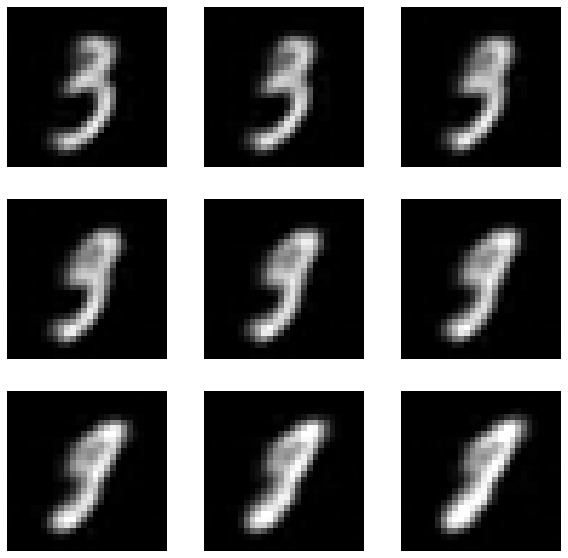

In [ ]:
plot_results(im_vergleich)